<a href="https://colab.research.google.com/github/teticio/audio-diffusion/blob/master/notebooks/test_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    # are we running on Google Colab?
    import google.colab
    !git clone -q https://github.com/teticio/audio-diffusion.git
    %cd audio-diffusion
    %pip install -q -r requirements.txt
except:
    pass

In [2]:
import os
import sys
sys.path.insert(0, os.path.dirname(os.path.abspath("")))

In [3]:
import torch
import random
import librosa
import numpy as np
from datasets import load_dataset
from IPython.display import Audio
from audiodiffusion import AudioDiffusion

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = torch.Generator(device=device)

## DDPM (De-noising Diffusion Probabilistic Models)

### Select model

In [5]:
#@markdown teticio/audio-diffusion-256                     - trained on my Spotify "liked" playlist

#@markdown teticio/audio-diffusion-breaks-256              - trained on samples used in music

#@markdown teticio/audio-diffusion-instrumental-hiphop-256 - trained on instrumental hiphop

model_id = "teticio/audio-diffusion-256"  #@param ["teticio/audio-diffusion-256", "teticio/audio-diffusion-breaks-256", "audio-diffusion-instrumenal-hiphop-256", "teticio/audio-diffusion-ddim-256"]

In [11]:
audio_diffusion.Mel

AttributeError: 'AudioDiffusion' object has no attribute 'Mel'

In [6]:
audio_diffusion = AudioDiffusion(model_id=model_id)
mel = audio_diffusion.pipe.mel

Downloading:   0%|          | 0.00/244 [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

### Run model inference to generate mel spectrogram, audios and loops

Seed = 3170503070637514


  0%|          | 0/1000 [00:00<?, ?it/s]

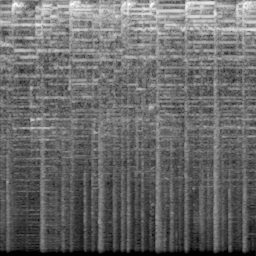

Seed = 2275699277188148


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
for _ in range(10):
    seed = generator.seed()
    print(f'Seed = {seed}')
    generator.manual_seed(seed)
    image, (sample_rate,
            audio) = audio_diffusion.generate_spectrogram_and_audio(
                generator=generator)
    display(image)
    display(Audio(audio, rate=sample_rate))
    loop = AudioDiffusion.loop_it(audio, sample_rate)
    if loop is not None:
        display(Audio(loop, rate=sample_rate))
    else:
        print("Unable to determine loop points")

### Generate variations of audios

Try playing around with `start_steps`. Values closer to zero will produce new samples, while values closer to 1,000 will produce samples more faithful to the original.

In [ ]:
seed = 2391504374279719  #@param {type:"integer"}
generator.manual_seed(seed)
image, (sample_rate, audio) = audio_diffusion.generate_spectrogram_and_audio(
    generator=generator)
display(image)
display(Audio(audio, rate=sample_rate))

In [ ]:
start_step = 500  #@param {type:"slider", min:0, max:1000, step:10}
track = AudioDiffusion.loop_it(audio, sample_rate, loops=1)
for variation in range(12):
    image2, (
        sample_rate,
        audio2) = audio_diffusion.generate_spectrogram_and_audio_from_audio(
            raw_audio=audio, start_step=start_step)
    display(image2)
    display(Audio(audio2, rate=sample_rate))
    track = np.concatenate(
        [track, AudioDiffusion.loop_it(audio2, sample_rate, loops=1)])
display(Audio(track, rate=sample_rate))

### Generate continuations ("out-painting")

In [ ]:
overlap_secs = 2  #@param {type:"integer"}
start_step = 0  #@param {type:"slider", min:0, max:1000, step:10}
overlap_samples = overlap_secs * sample_rate
track = audio
for variation in range(12):
    image2, (
        sample_rate,
        audio2) = audio_diffusion.generate_spectrogram_and_audio_from_audio(
            raw_audio=audio[-overlap_samples:],
            start_step=start_step,
            mask_start_secs=overlap_secs)
    display(image2)
    display(Audio(audio2, rate=sample_rate))
    track = np.concatenate([track, audio2[overlap_samples:]])
    audio = audio2
display(Audio(track, rate=sample_rate))

### Remix (style transfer)

Alternatively, you can start from another audio altogether, resulting in a kind of style transfer. Maintaining the same seed during generation fixes the style, while masking helps stitch consecutive segments together more smoothly.

In [ ]:
try:
    # are we running on Google Colab?
    from google.colab import files
    audio_file = list(files.upload().keys())[0]
except:
    audio_file = "/home/teticio/Music/liked/El Michels Affair - Glaciers Of Ice.mp3"

In [ ]:
start_step = 500  #@param {type:"slider", min:0, max:1000, step:10}
overlap_secs = 2  #@param {type:"integer"}
track_audio, _ = librosa.load(audio_file, mono=True, sr=mel.get_sample_rate())
overlap_samples = overlap_secs * sample_rate
slice_size = mel.x_res * mel.hop_length
stride = slice_size - overlap_samples
generator = torch.Generator(device=device)
seed = generator.seed()
print(f'Seed = {seed}')
track = np.array([])
not_first = 0
for sample in range(len(track_audio) // stride):
    generator.manual_seed(seed)
    audio = np.array(track_audio[sample * stride:sample * stride + slice_size])
    if not_first:
        # Normalize and re-insert generated audio
        audio[:overlap_samples] = audio2[-overlap_samples:] * np.max(
            audio[:overlap_samples]) / np.max(audio2[-overlap_samples:])
    _, (sample_rate,
        audio2) = audio_diffusion.generate_spectrogram_and_audio_from_audio(
            raw_audio=audio,
            start_step=start_step,
            generator=generator,
            mask_start_secs=overlap_secs * not_first)
    track = np.concatenate([track, audio2[overlap_samples * not_first:]])
    not_first = 1
    display(Audio(track, rate=sample_rate))

### Fill the gap ("in-painting")

In [ ]:
slice = 3  #@param {type:"integer"}
raw_audio = track_audio[sample * stride:sample * stride + slice_size]
_, (sample_rate,
    audio2) = audio_diffusion.generate_spectrogram_and_audio_from_audio(
        raw_audio=raw_audio,
        mask_start_secs=1,
        mask_end_secs=1,
        step_generator=torch.Generator(device=device))
display(Audio(audio, rate=sample_rate))
display(Audio(audio2, rate=sample_rate))

## DDIM (De-noising Diffusion Implicit Models)

In [ ]:
audio_diffusion = AudioDiffusion(model_id='teticio/audio-diffusion-ddim-256')
mel = audio_diffusion.pipe.mel

### Generation can be done in many fewer steps with DDIMs

In [ ]:
for _ in range(10):
    seed = generator.seed()
    print(f'Seed = {seed}')
    generator.manual_seed(seed)
    image, (sample_rate,
            audio) = audio_diffusion.generate_spectrogram_and_audio(
                generator=generator)
    display(image)
    display(Audio(audio, rate=sample_rate))
    loop = AudioDiffusion.loop_it(audio, sample_rate)
    if loop is not None:
        display(Audio(loop, rate=sample_rate))
    else:
        print("Unable to determine loop points")

The parameter eta controls the variance:
* 0 - DDIM (deterministic)
* 1 - DDPM (De-noising Diffusion Probabilistic Model)

In [ ]:
image, (sample_rate, audio) = audio_diffusion.generate_spectrogram_and_audio(
    steps=1000, generator=generator, eta=1)
display(image)
display(Audio(audio, rate=sample_rate))

### DDIMs can be used as encoders...

In [ ]:
# Doesn't have to be an audio from the train dataset, this is just for convenience
ds = load_dataset('teticio/audio-diffusion-256')

In [ ]:
image = ds['train'][264]['image']
display(Audio(mel.image_to_audio(image), rate=sample_rate))

In [ ]:
noise = audio_diffusion.pipe.encode([image])

In [ ]:
# Reconstruct original audio from noise
_, (sample_rate, audio) = audio_diffusion.generate_spectrogram_and_audio(
    noise=noise, generator=generator)
display(Audio(audio, rate=sample_rate))

### ...or to interpolate between audios

In [ ]:
image2 = ds['train'][15978]['image']
display(Audio(mel.image_to_audio(image2), rate=sample_rate))

In [ ]:
noise2 = audio_diffusion.pipe.encode([image2])

In [ ]:
alpha = 0.5  #@param {type:"slider", min:0, max:1, step:0.1}
_, (sample_rate, audio) = audio_diffusion.generate_spectrogram_and_audio(
    noise=audio_diffusion.pipe.slerp(noise, noise2, alpha),
    generator=generator)
display(Audio(mel.image_to_audio(image), rate=sample_rate))
display(Audio(mel.image_to_audio(image2), rate=sample_rate))
display(Audio(audio, rate=sample_rate))

## Latent Audio Diffusion
Instead of de-noising images directly in the pixel space, we can work in the latent space of a pre-trained VAE (Variational AutoEncoder). This is much faster to train and run inference on, although the quality suffers as there are now three stages involved in encoding / decoding: mel spectrogram, VAE and de-noising.

In [ ]:
model_id = "teticio/latent-audio-diffusion-ddim-256"  #@param ["teticio/latent-audio-diffusion-256", "teticio/latent-audio-diffusion-ddim-256"]

In [ ]:
audio_diffusion = AudioDiffusion(model_id=model_id)
mel = audio_diffusion.pipe.mel

In [ ]:
seed = 3412253600050855  #@param {type:"integer"}
generator.manual_seed(seed)
image, (sample_rate, audio) = audio_diffusion.generate_spectrogram_and_audio(
    generator=generator)
display(image)
display(Audio(audio, rate=sample_rate))

In [ ]:
seed2 = 7016114633369557  #@param {type:"integer"}
generator.manual_seed(seed2)
image2, (sample_rate, audio2) = audio_diffusion.generate_spectrogram_and_audio(
    generator=generator)
display(image2)
display(Audio(audio2, rate=sample_rate))

### Interpolation in latent space
As the VAE forces a more compact, lower dimensional representation for the spectrograms, interpolation in latent space can lead to meaningful combinations of audios. In combination with the (deterministic) DDIM from the previous section, the model can be used as an encoder / decoder to a lower dimensional space.

In [ ]:
generator.manual_seed(seed)
latents = torch.randn((1, audio_diffusion.pipe.unet.in_channels,
                       audio_diffusion.pipe.unet.sample_size[0],
                       audio_diffusion.pipe.unet.sample_size[1]),
                      device=device,
                      generator=generator)
latents.shape

In [ ]:
generator.manual_seed(seed2)
latents2 = torch.randn((1, audio_diffusion.pipe.unet.in_channels,
                        audio_diffusion.pipe.unet.sample_size[0],
                        audio_diffusion.pipe.unet.sample_size[1]),
                       device=device,
                       generator=generator)
latents2.shape

In [ ]:
alpha = 0.5  #@param {type:"slider", min:0, max:1, step:0.1}
_, (sample_rate, audio3) = audio_diffusion.generate_spectrogram_and_audio(
    noise=audio_diffusion.pipe.slerp(latents, latents2, alpha),
    generator=generator)
display(Audio(audio, rate=sample_rate))
display(Audio(audio2, rate=sample_rate))
display(Audio(audio3, rate=sample_rate))